# 第6章 与学习相关的技巧


本章将介绍神经网络的学习中的一些重要观点，主题涉及寻找最优权重 参数的最优化方法、权重参数的初始值、超参数的设定方法等。此外，为了 应对过拟合，本章还将介绍权值衰减、Dropout等正则化方法，并进行实现。 最后将对近年来众多研究中使用的Batch Normalization方法进行简单的介绍。 使用本章介绍的方法，可以高效地进行神经网络（深度学习）的学习，提高 识别精度。让我们一起往下看吧

## 6.1 参数的更新


我们将指出SGD的缺点，并介绍SGD以外的其他最优化方法

### 6.1.1　探险家的故事


寻找最优参数时，我们所处的状况和这位探险家一样，是一个漆黑的世 界。我们必须在没有地图、不能睁眼的情况下，在广袤、复杂的地形中寻找 “至深之地”。大家可以想象这是一个多么难的问题。 在这么困难的状况下，地面的坡度显得尤为重要。探险家虽然看不到周 围的情况，但是能够知道当前所在位置的坡度（通过脚底感受地面的倾斜状况）。 于是，朝着当前所在位置的坡度最大的方向前进，就是SGD的策略。勇敢 的探险家心里可能想着只要重复这一策略，总有一天可以到达“至深之地”。


### 6.1.2　SGD

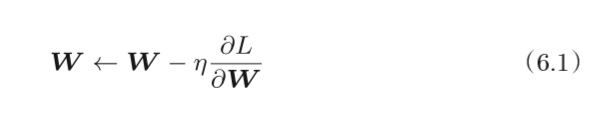

这里把需要更新的权重参数记为W，把损失函数关于W的梯度记为 。 η表示学习率，实际上会取0.01或0.001这些事先决定好的值。式子中的←
表示用右边的值更新左边的值。如式（6.1）所示， SGD是朝着梯度方向只前 进一定距离的简单方法。现在，我们将SGD实现为一个Python类（为方便 后面使用，我们将其实现为一个名为SGD的类）。


In [3]:
class SGD:
    def __init__(self,lr = 0.01):
        self.lr = lr
    def update(self,params,grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

这里，进行初始化时的参数lr表示learning rate（学习率）。这个学习率 会保存为实例变量。此外，代码段中还定义了update(params, grads)方法， 这个方法在SGD中会被反复调用。参数params和grads（与之前的神经网络 的实现一样）是字典型变量，按params['W1']、grads['W1']的形式，分别保 存了权重参数和它们的梯度。 

使用这个SGD类，可以按如下方式进行神经网络的参数的更新（下面的 代码是不能实际运行的伪代码）。


### 6.1.3　SGD的缺点

虽然SGD简单，并且容易实现，但是在解决某些问题时可能没有效率。 这里，在指出SGD的缺点之际，我们来思考一下求下面这个函数的最小值 的问题。
 

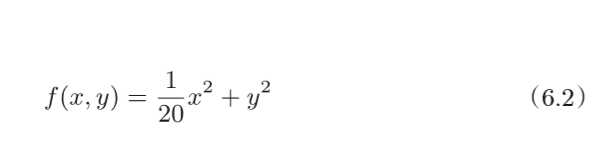

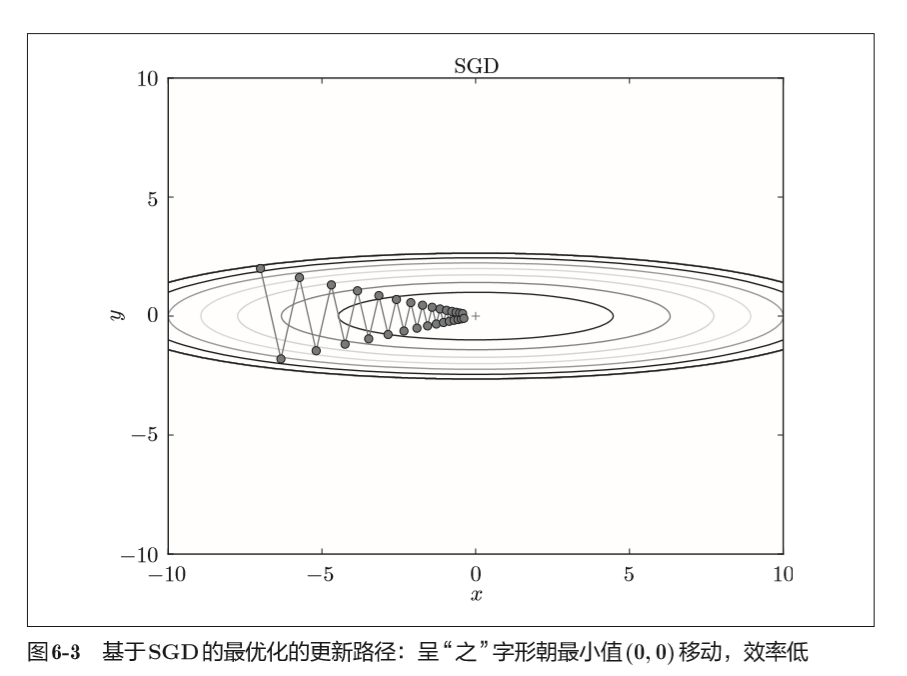

### 6.1.4　Momentum


Momentum是“动量”的意思，和物理有关。用数学式表示Momentum方 法，如下所示。
 

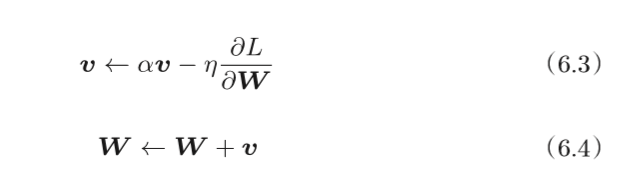

和前面的SGD一样，W表示要更新的权重参数， 表示损失函数关 于W的梯度，η表示学习率。这里新出现了一个变量v，对应物理上的速度。 式（6.3）表示了物体在梯度方向上受力，在这个力的作用下，物体的速度增 加这一物理法则。如图6-4所示，Momentum方法给人的感觉就像是小球在 地面上滚动。

式（6.3）中有 αv这一项。在物体不受任何力时，该项承担使物体逐渐减 速的任务（α设定为0.9之类的值），对应物理上的地面摩擦或空气阻力。下 面是Momentum的代码实现（源代码在common/optimizer.py中）。


In [4]:
class Momentum:
    def __init__(self,lr = 0.01,momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self,params,grads):
        if self.v is None:
            self.v = {}
            for key,val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] +=self.v[key]

实例变量v会保存物体的速度。初始化时，v中什么都不保存，但当第 一次调用update()时，v会以字典型变量的形式保存与参数结构相同的数据。 剩余的代码部分就是将式（6.3）、式（ 6.4）写出来，很简单。 

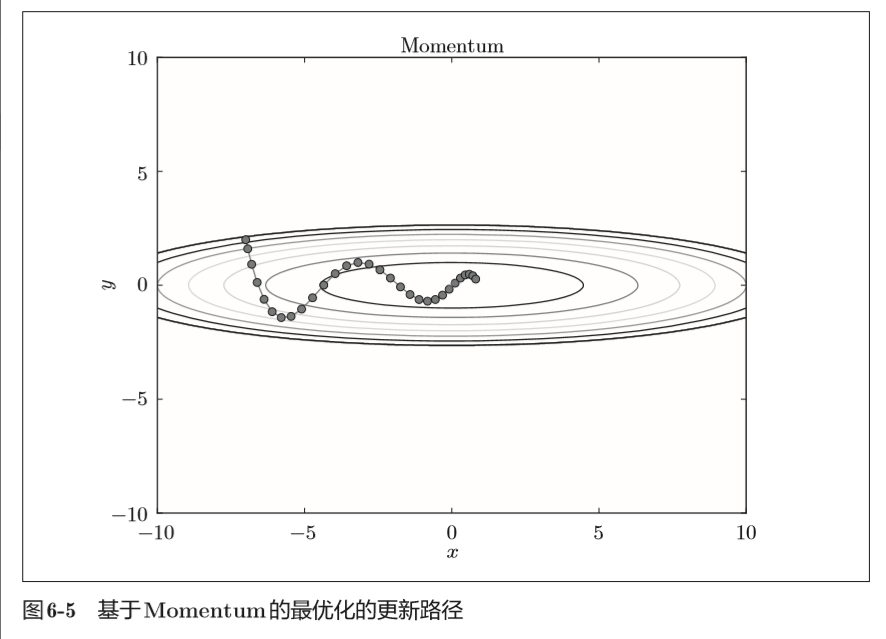

### 6.1.5　AdaGrad


在神经网络的学习中，学习率（数学式中记为η）的值很重要。学习率过小， 会导致学习花费过多时间；反过来，学习率过大，则会导致学习发散而不能 正确进行。 

在关于学习率的有效技巧中，有一种被称为学习率衰减（learning rate decay）的方法，即随着学习的进行，使学习率逐渐减小。实际上，一开始“多” 学，然后逐渐“少”学的方法，在神经网络的学习中经常被使用。 

逐渐减小学习率的想法，相当于将“全体”参数的学习率值一起降低。 而AdaGrad [6]进一步发展了这个想法，针对“一个一个”的参数，赋予其“定 制”的值。 

AdaGrad会为参数的每个元素适当地调整学习率，与此同时进行学习 （AdaGrad的Ada来自英文单词Adaptive，即“适当的”的意思）。下面，让 我们用数学式表示AdaGrad的更新方法。

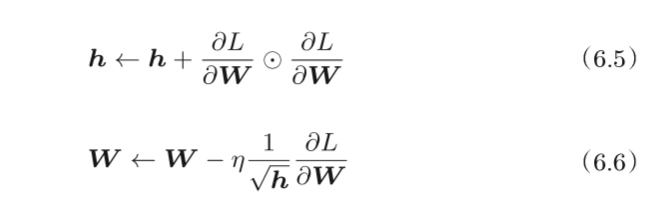

和前面的SGD一样，W表示要更新的权重参数， 表示损失函数关 于W的梯度，η表示学习率。这里新出现了变量h，如式(6.5)所示，它保 存了以前的所有梯度值的平方和（式（6.5）中的 表示对应矩阵元素的乘法）。 然后，在更新参数时，通过乘以 ，就可以调整学习的尺度。这意味着， 参数的元素中变动较大（被大幅更新）的元素的学习率将变小。也就是说， 可以按参数的元素进行学习率衰减，使变动大的参数的学习率逐渐减小。

现在来实现AdaGrad。AdaGrad的实现过程如下所示（源代码在 common/optimizer.py中）。


In [5]:
class AdaGrad:
    def __init__(self,lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self,params,grads):
        if self.h is None:
            self.h = {}
            for key,val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key]*grads[key]
            params[key] -= self.lr * grads[key]/(np.sqrt(self.h[key] + 1e-7))

这里需要注意的是，最后一行加上了微小值1e-7。这是为了防止当 self.h[key]中有0时，将0用作除数的情况。在很多深度学习的框架中，这 个微小值也可以设定为参数，但这里我们用的是1e-7这个固定值

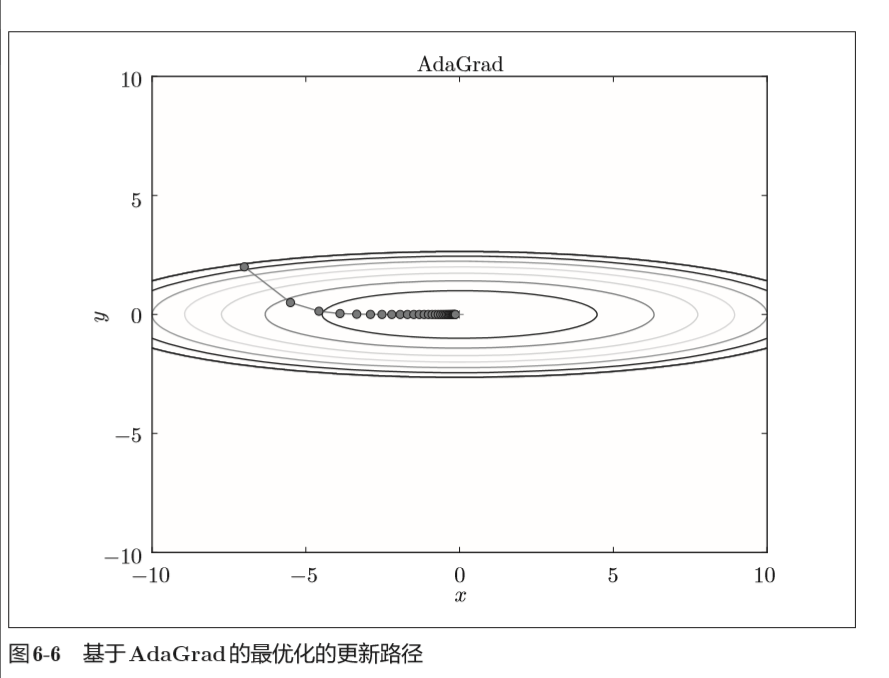

由图6-6的结果可知，函数的取值高效地向着最小值移动。由于y轴方 向上的梯度较大，因此刚开始变动较大，但是后面会根据这个较大的变动按 比例进行调整，减小更新的步伐。因此，y轴方向上的更新程度被减弱，“之” 字形的变动程度有所衰减。


### 6.1.6　Adam


Momentum参照小球在碗中滚动的物理规则进行移动，AdaGrad为参 数的每个元素适当地调整更新步伐。如果将这两个方法融合在一起会怎么样呢？这就是Adam[8]方法的基本思路 A。 

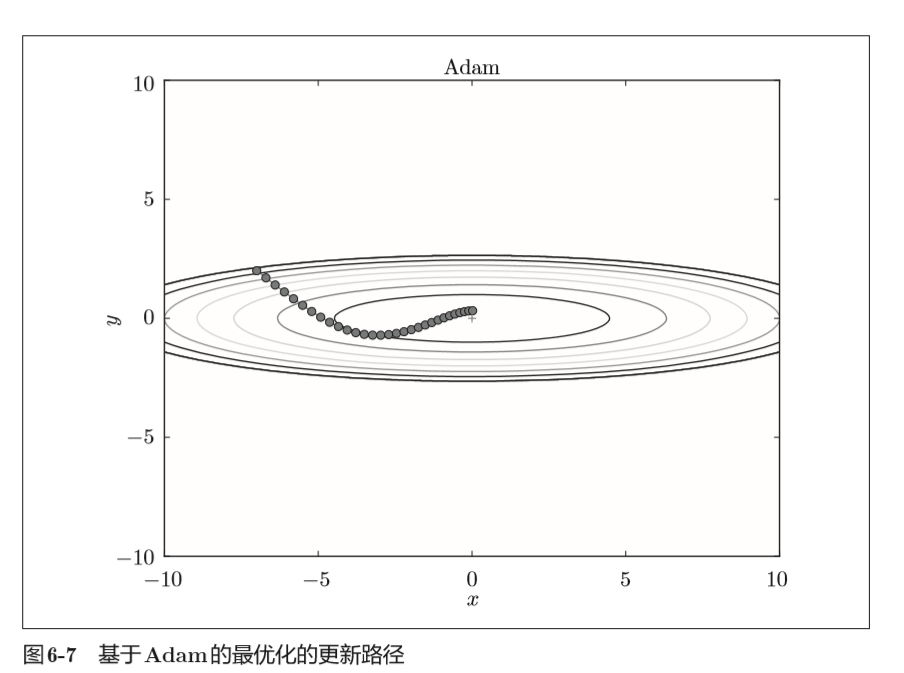

在图6-7中，基于Adam的更新过程就像小球在碗中滚动一样。虽然 Momentun也有类似的移动，但是相比之下，Adam的小球左右摇晃的程度 有所减轻。这得益于学习的更新程度被适当地调整了。


Adam会设置3个超参数。一个是学习率（论文中以α出现），另外两 个是一次momentum系数β1和二次momentum系数β2。根据论文， 标准的设定值是β1为0.9，β2 为0.999。设置了这些值后，大多数情 况下都能顺利运行。


## 6.2 权重的初始值


在神经网络的学习中，权重的初始值特别重要。实际上，设定什么样的 权重初始值，经常关系到神经网络的学习能否成功。本节将介绍权重初始值 的推荐值，并通过实验确认神经网络的学习是否会快速进行。


### 6.2.1　可以将权重初始值设为0吗


后面我们会介绍抑制过拟合、提高泛化能力的技巧——权值衰减（weight decay）。简单地说，权值衰减就是一种以减小权重参数的值为目的进行学习 的方法。通过减小权重参数的值来抑制过拟合的发生。 

如果想减小权重的值，一开始就将初始值设为较小的值才是正途。实际上， 在这之前的权重初始值都是像0.01 * np.random.randn(10, 100)这样，使用 由高斯分布生成的值乘以0.01后得到的值（标准差为0.01的高斯分布）。 

如果我们把权重初始值全部设为0以减小权重的值，会怎么样呢？从结 论来说，将权重初始值设为0不是一个好主意。事实上，将权重初始值设为 0的话，将无法正确进行学习。 

为什么不能将权重初始值设为0呢？严格地说，为什么不能将权重初始 值设成一样的值呢？这是因为在误差反向传播法中，所有的权重值都会进行 相同的更新。比如，在2层神经网络中，假设第1层和第2层的权重为0。这 样一来，正向传播时，因为输入层的权重为0，所以第2层的神经元全部会 被传递相同的值。第2层的神经元中全部输入相同的值，这意味着反向传播 时第2层的权重全部都会进行相同的更新（回忆一下“乘法节点的反向传播的内容）。因此，权重被更新为相同的值，并拥有了对称的值（重复的值）。 这使得神经网络拥有许多不同的权重的意义丧失了。为了防止“权重均一化” （严格地讲，是为了瓦解权重的对称结构），必须随机生成初始值。


### 6.2.2　隐藏层的激活值的分布


观察隐藏层的激活值 A（激活函数的输出数据）的分布，可以获得很多启 发。这里，我们来做一个简单的实验，观察权重初始值是如何影响隐藏层的 激活值的分布的。这里要做的实验是，向一个5层神经网络（激活函数使用 sigmoid函数）传入随机生成的输入数据，用直方图绘制各层激活值的数据分 布。这个实验参考了斯坦福大学的课程CS231n [5]。 

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.random.randn(1000,100)#1000个数据
node_num = 100#各隐藏层的节点（神经元）数
hidden_layer_size = 5#隐藏层有5层
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num,node_num)*1
    
    z = np.dot(x,w)
    a = sigmoid(z)
    activations[i] = a

这里假设神经网络有5层，每层有100个神经元。然后，用高斯分布随 机生成1000个数据作为输入数据，并把它们传给5层神经网络。激活函数使 用sigmoid函数，各层的激活值的结果保存在activations变量中。这个代码 段中需要注意的是权重的尺度。虽然这次我们使用的是标准差为1的高斯分 布，但实验的目的是通过改变这个尺度（标准差），观察激活值的分布如何变 化。现在，我们将保存在activations中的各层数据画成直方图。


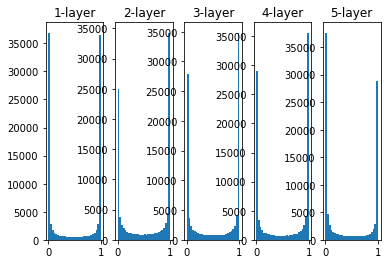

In [7]:
for i,a in activations.items():
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

从图6-10可知，各层的激活值呈偏向0和1的分布。这里使用的sigmoid 函数是S型函数，随着输出不断地靠近0（或者靠近1），它的导数的值逐渐接 近0。因此，偏向0和1的数据分布会造成反向传播中梯度的值不断变小，最 后消失。这个问题称为梯度消失（gradient vanishing）。层次加深的深度学习 中，梯度消失的问题可能会更加严重。 

下面，将权重的标准差设为0.01，进行相同的实验。实验的代码只需要 把设定权重初始值的地方换成下面的代码即可。


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.random.randn(1000,100)#1000个数据
node_num = 100#各隐藏层的节点（神经元）数
hidden_layer_size = 5#隐藏层有5层
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num,node_num)*0.01
    
    z = np.dot(x,w)
    a = sigmoid(z)
    activations[i] = a

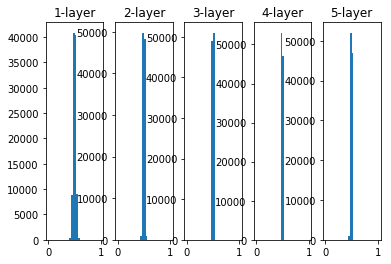

In [9]:
for i,a in activations.items():
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

这次呈集中在0.5附近的分布。因为不像刚才的例子那样偏向0和1，所 以不会发生梯度消失的问题。但是，激活值的分布有所偏向，说明在表现力 上会有很大问题。为什么这么说呢？因为如果有多个神经元都输出几乎相同 的值，那它们就没有存在的意义了。比如，如果100个神经元都输出几乎相 同的值，那么也可以由1个神经元来表达基本相同的事情。因此，激活值在 分布上有所偏向会出现“表现力受限”的问题。


各层的激活值的分布都要求有适当的广度。为什么呢？因为通过 在各层间传递多样性的数据，神经网络可以进行高效的学习。反 过来，如果传递的是有所偏向的数据，就会出现梯度消失或者“表 现力受限”的问题，导致学习可能无法顺利进行。


接着，我们尝试使用Xavier Glorot等人的论文[9]中推荐的权重初始值（俗 称“ Xavier初始值”）。现在，在一般的深度学习框架中，Xavier初始值已被 作为标准使用。比如，Caffe框架中，通过在设定权重初始值时赋予xavier参数， 就可以使用Xavier初始值。 

Xavier的论文中，为了使各层的激活值呈现出具有相同广度的分布，推
导了合适的权重尺度。推导出的结论是，如果前一层的节点数为n，则初始 值使用标准差为 的分布A （图 6-12）。


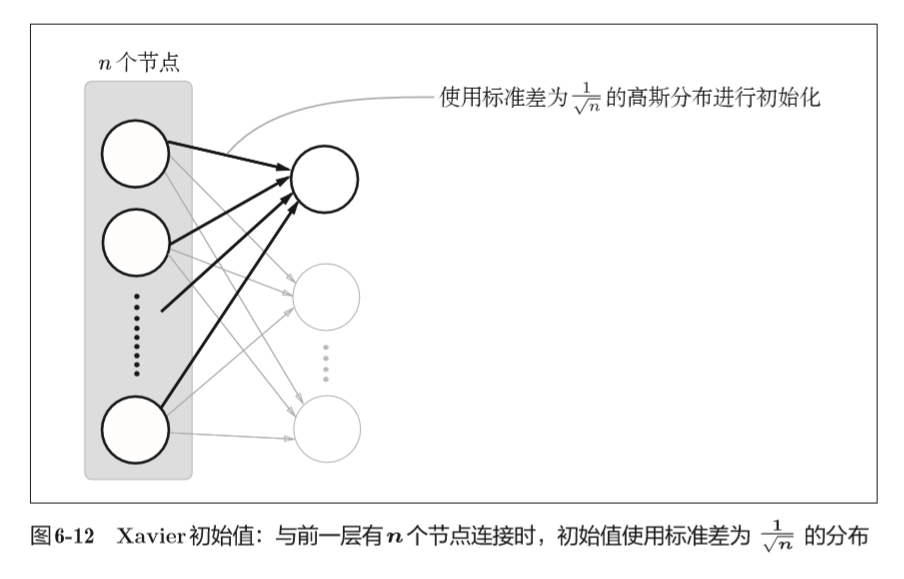

使用Xavier初始值后，前一层的节点数越多，要设定为目标节点的初始 值的权重尺度就越小。现在，我们使用Xavier初始值进行实验。进行实验的 代码只需要将设定权重初始值的地方换成如下内容即可（因为此处所有层的 节点数都是100，所以简化了实现）。


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-x))

x = np.random.randn(1000,100)#1000个数据
node_num = 100#各隐藏层的节点（神经元）数
hidden_layer_size = 5#隐藏层有5层
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num,node_num)/np.sqrt(node_num)
    
    z = np.dot(x,w)
    a = sigmoid(z)
    activations[i] = a

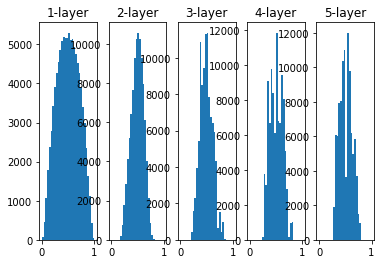

In [12]:
for i,a in activations.items():
    plt.subplot(1,len(activations),i+1)
    plt.title(str(i+1) + '-layer')
    plt.hist(a.flatten(),30,range=(0,1))
plt.show()

使用Xavier初始值后的结果如图6-13所示。从这个结果可知，越是后 面的层，图像变得越歪斜，但是呈现了比之前更有广度的分布。因为各层间 传递的数据有适当的广度，所以sigmoid函数的表现力不受限制，有望进行 高效的学习。


图6-13的分布中，后面的层的分布呈稍微歪斜的形状。如果用tanh 函数（双曲线函数）代替sigmoid函数，这个稍微歪斜的问题就能得 到改善。实际上，使用tanh函数后，会呈漂亮的吊钟型分布。tanh 函数和sigmoid函数同是S型曲线函数，但tanh函数是关于原点(0, 0) 对称的S型曲线，而sigmoid函数是关于(x, y)=(0,0.5)对称的S型曲 线。众所周知，用作激活函数的函数最好具有关于原点对称的性质。


### 6.2.3　ReLU的权重初始值

Xavier初始值是以激活函数是线性函数为前提而推导出来的。因为 sigmoid函数和tanh函数左右对称，且中央附近可以视作线性函数，所以适 合使用Xavier初始值。但当激活函数使用ReLU时，一般推荐使用ReLU专 用的初始值，也就是Kaiming He等人推荐的初始值，也称为“He初始值”[10]。 当前一层的节点数为n时，He初始值使用标准差为 的高斯分布。当 Xavier初始值是 时，（直观上）可以解释为，因为ReLU的负值区域的值 为0，为了使它更有广度，所以需要2倍的系数。 

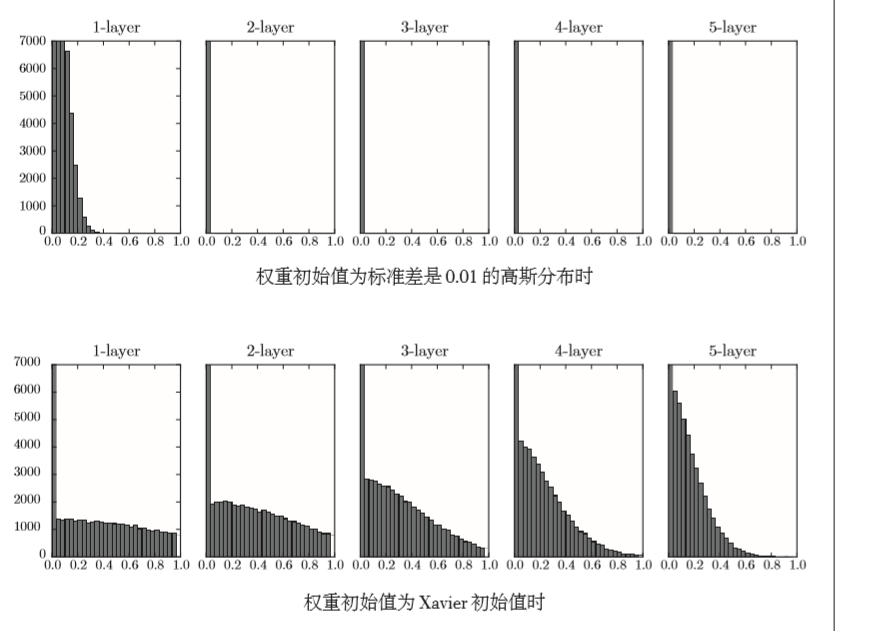

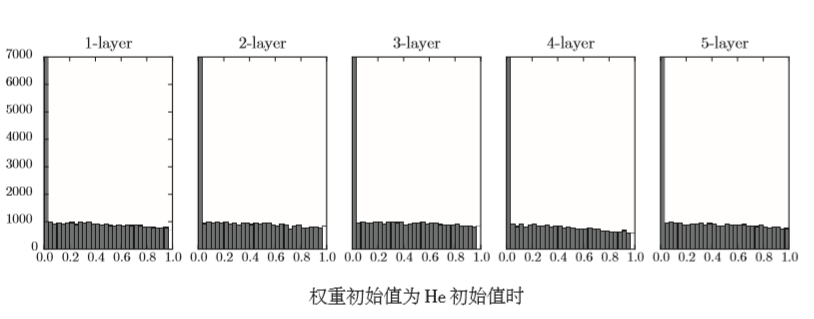

总结一下，当激活函数使用ReLU时，权重初始值使用He初始值，当 激活函数为sigmoid或tanh等S型曲线函数时，初始值使用Xavier初始值。 这是目前的最佳实践。


## 6.3 Batch Normalization


在上一节，我们观察了各层的激活值分布，并从中了解到如果设定了合 适的权重初始值，则各层的激活值分布会有适当的广度，从而可以顺利地进 行学习。那么，为了使各层拥有适当的广度，“强制性”地调整激活值的分布 会怎样呢？实际上，Batch Normalization[11]方法就是基于这个想法而产生的。


### 6.3.1　Batch Normalization 的算法


Batch Norm有以下优点。


• 可以使学习快速进行（可以增大学习率）。 

• 不那么依赖初始值（对于初始值不用那么神经质）。 

• 抑制过拟合（降低Dropout等的必要性）。

如前所述，Batch Norm的思路是调整各层的激活值分布使其拥有适当 的广度。为此，要向神经网络中插入对数据分布进行正规化的层，即Batch Normalization层（下文简称Batch Norm层），如图6-16所示。


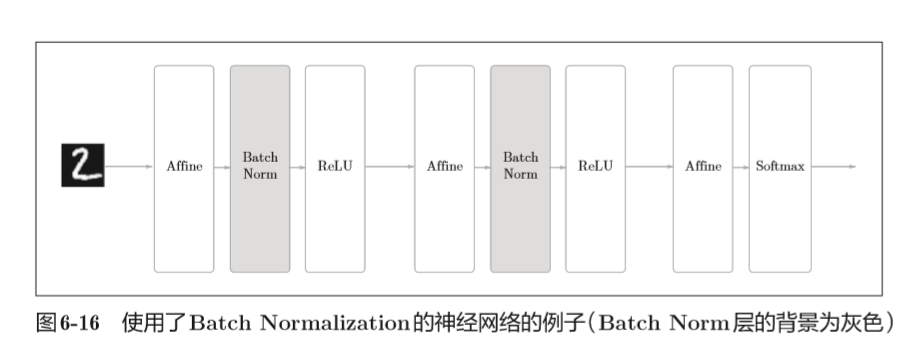

Batch Norm，顾名思义，以进行学习时的mini-batch为单位，按minibatch进行正规化。具体而言，就是进行使数据分布的均值为0、方差为1的 正规化。用数学式表示的话，如下所示。
 

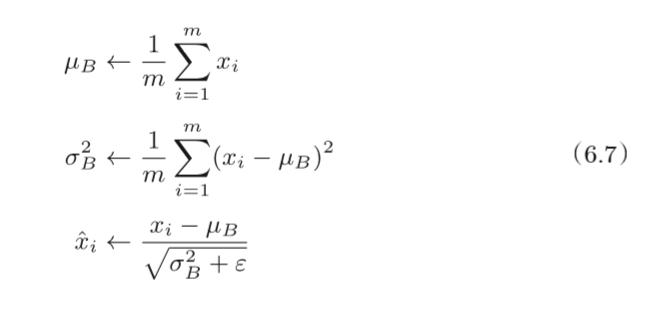

这里对mini-batch的m个输入数据的集合B ={x1,x 2,...,xm}求均值 µB和方差 。然后，对输入数据进行均值为0、方差为1（合适的分布）的 正规化。式（6.7）中的 ε是一个微小值（比如，10e-7等），它是为了防止出现 除以0的情况。

式（6.7）所做的是将mini-batch的输入数据{x1,x 2,...,xm}变换为均值为0、方差为1的数据 ，非常简单。通过将这个处理插入到 激活函数的前面（或者后面）A，可以减小数据分布的偏向。 

接着，Batch Norm层会对正规化后的数据进行缩放和平移的变换，用 数学式可以如下表示。
 

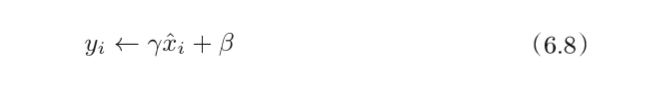

这里，γ和β是参数。一开始γ = 1，β = 0，然后再通过学习调整到合 适的值。 

## 6.4 正则化

机器学习的问题中，过拟合是一个很常见的问题。过拟合指的是只能拟 合训练数据，但不能很好地拟合不包含在训练数据中的其他数据的状态。机 器学习的目标是提高泛化能力，即便是没有包含在训练数据里的未观测数据， 也希望模型可以进行正确的识别。我们可以制作复杂的、表现力强的模型，但是相应地，抑制过拟合的技巧也很重要。


### 6.4.1　过拟合


发生过拟合的原因，主要有以下两个。


• 模型拥有大量参数、表现力强。 

• 训练数据少。


### 6.4.2　权值衰减

权值衰减是一直以来经常被使用的一种抑制过拟合的方法。该方法通过 在学习的过程中对大的权重进行惩罚，来抑制过拟合。很多过拟合原本就是 因为权重参数取值过大才发生的。 

复习一下，神经网络的学习目的是减小损失函数的值。这时，例如为 损失函数加上权重的平方范数（L2范数）。这样一来，就可以抑制权重变大。 用符号表示的话，如果将权重记为W，L2范数的权值衰减就是 ，然 后将这个 加到损失函数上。这里，λ是控制正则化强度的超参数。λ 设置得越大，对大的权重施加的惩罚就越重。此外， 开头的 是用于 将 的求导结果变成λW的调整用常量。 对于所有权重，权值衰减方法都会为损失函数加上 。因此，在求权 重梯度的计算中，要为之前的误差反向传播法的结果加上正则化项的导数λW。


L2范数相当于各个元素的平方和。用数学式表示的话，假设有权重 W = (w1,w 2,...,wn)，则L2范数可用 计算 出来。除了L2范数，还有L1范数、L∞范数等。L1范数是各个元 素的绝对值之和，相当于|w1| + |w2| + ...+ |wn|。L∞范数也称为 Max范数，相当于各个元素的绝对值中最大的那一个。L2范数、L1 范数、L∞范数都可以用作正则化项，它们各有各的特点，不过这里 我们要实现的是比较常用的L2范数。


### 6.4.3　Dropout


作为抑制过拟合的方法，前面我们介绍了为损失函数加上权重的L2范 数的权值衰减方法。该方法可以简单地实现，在某种程度上能够抑制过拟合。 但是，如果网络的模型变得很复杂，只用权值衰减就难以应对了。在这种情 况下，我们经常会使用Dropout [14]方法。 

Dropout是一种在学习的过程中随机删除神经元的方法。训练时，随机 选出隐藏层的神经元，然后将其删除。被删除的神经元不再进行信号的传递， 如图6-22所示。训练时，每传递一次数据，就会随机选择要删除的神经元。 然后，测试时，虽然会传递所有的神经元信号，但是对于各个神经元的输出， 要乘上训练时的删除比例后再输出。

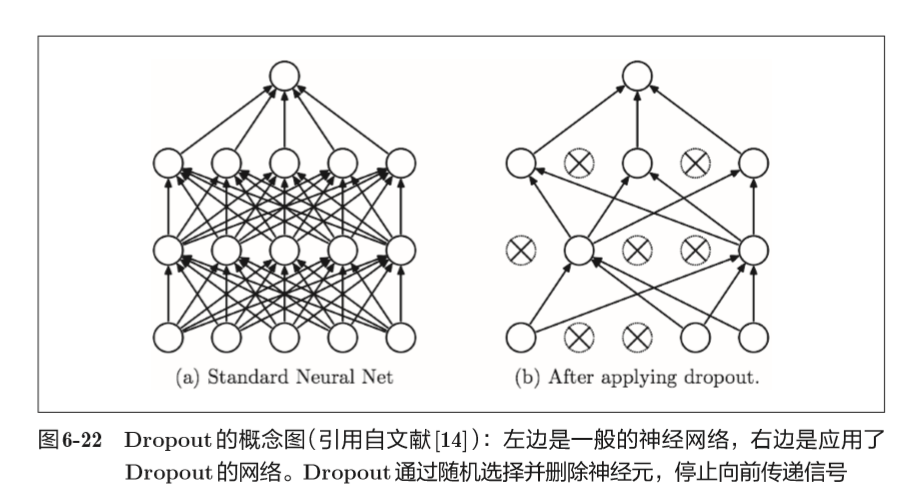

## 6.5 超参数的验证

神经网络中，除了权重和偏置等参数，超参数（hyper-parameter）也经 常出现。这里所说的超参数是指，比如各层的神经元数量、batch大小、参 数更新时的学习率或权值衰减等。如果这些超参数没有设置合适的值，模型 的性能就会很差。虽然超参数的取值非常重要，但是在决定超参数的过程中 一般会伴随很多的试错。本节将介绍尽可能高效地寻找超参数的值的方法。


### 6.5.1　验证数据


下面我们要对超参数设置各种各样的值以进行验证。这里要注意的是， 不能使用测试数据评估超参数的性能。这一点非常重要，但也容易被忽视。 

为什么不能用测试数据评估超参数的性能呢？这是因为如果使用测试数 据调整超参数，超参数的值会对测试数据发生过拟合。换句话说，用测试数 据确认超参数的值的“好坏”，就会导致超参数的值被调整为只拟合测试数据。 这样的话，可能就会得到不能拟合其他数据、泛化能力低的模型。 

因此，调整超参数时，必须使用超参数专用的确认数据。用于调整超参 数的数据，一般称为验证数据（validation data）。我们使用这个验证数据来 评估超参数的好坏。

训练数据用于参数（权重和偏置）的学习，验证数据用于超参数的性 能评估。为了确认泛化能力，要在最后使用（比较理想的是只用一次） 测试数据。


根据不同的数据集，有的会事先分成训练数据、验证数据、测试数据三 部分，有的只分成训练数据和测试数据两部分，有的则不进行分割。在这种 情况下，用户需要自行进行分割。如果是MNIST数据集，获得验证数据的 最简单的方法就是从训练数据中事先分割20%作为验证数据，代码如下所示。


In [16]:
import sys,os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test) = load_mnist()

In [ ]:
#打乱数据
x_train,t_train = shuffle_dataset(x_train,t_train)

In [18]:
#分割验证集
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

In [19]:
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

### 6.5.2　超参数的最优化

进行超参数的最优化时，逐渐缩小超参数的“好值”的存在范围非常重要。 所谓逐渐缩小范围，是指一开始先大致设定一个范围，从这个范围中随机选 出一个超参数（采样），用这个采样到的值进行识别精度的评估；然后，多次 重复该操作，观察识别精度的结果，根据这个结果缩小超参数的“好值”的范围。 通过重复这一操作，就可以逐渐确定超参数的合适范围

有报告[15]显示，在进行神经网络的超参数的最优化时，与网格搜索 等有规律的搜索相比，随机采样的搜索方式效果更好。这是因为在 多个超参数中，各个超参数对最终的识别精度的影响程度不同。


超参数的范围只要“大致地指定”就可以了。所谓“大致地指定”，是指 像0.001（10−3）到 1000（103）这样，以“ 10的阶乘”的尺度指定范围（也表述 为“用对数尺度（log scale）指定”）。 

在超参数的最优化中，要注意的是深度学习需要很长时间（比如，几天 或几周）。因此，在超参数的搜索中，需要尽早放弃那些不符合逻辑的超参数。 于是，在超参数的最优化中，减少学习的epoch，缩短一次评估所需的时间 是一个不错的办法。 

#### 步骤0 

设定超参数的范围。


#### 步骤1 

从设定的超参数范围中随机采样。


#### 步骤2 

使用步骤1中采样到的超参数的值进行学习，通过验证数据评估识别精 度（但是要将epoch设置得很小）。


#### 步骤3 

重复步骤1和步骤2（100次等），根据它们的识别精度的结果，缩小超参 数的范围。


反复进行上述操作，不断缩小超参数的范围，在缩小到一定程度时，从 该范围中选出一个超参数的值。这就是进行超参数的最优化的一种方法。

#### 本章所学的内容

•  参数的更新方法，除了SGD之外，还有Momentum、AdaGrad、 Adam等方法

• 权重初始值的赋值方法对进行正确的学习非常重要。 

• 作为权重初始值，Xavier初始值、He初始值等比较有效。 

•  通过使用Batch Normalization，可以加速学习，并且对初始值变得 健壮。 

• 抑制过拟合的正则化技术有权值衰减、Dropout等。 

• 逐渐缩小“好值”存在的范围是搜索超参数的一个有效方法。